# A simple graphical model containing Dirichlet, Polya (Dirichlet-Multinomial) and categorical distributions


In [1]:
# %matplotlib inline 
import numpy as np
import scipy as sc
from matplotlib import pylab as plt
from matplotlib import rc, rcParams
from scipy.special import gamma
from scipy import integrate



### Change the following to simulate various combinations of Dirichlet and Categorical distributions


We can change the following parameters:  
1) The 'a' array contains the $\alpha$ values for the Dirichlet prior - determining the message from the Dirichlet towards the Polya. In the 2D case we have $[\alpha_1, \alpha_2]$ and in general $[\alpha_1,...,\alpha_k,...\alpha_K]$
2) The 'pZ' array contains the distribution over $Z$ assumed to be passed back from beyond the Polya towards the Polya. In the 2D case we have $[p_1, p_2]$ and in general $[p_1,...,p_k,...p_K]$


Note: 'ac' and 'capZ', they are automatically generated normalisation constants dependent on the above. 


In [2]:
N = 1 # used to simulate message passing after multiple epocs (1 is for initial case)
pZ = np.array([0.1, 0.9]) # distribution (incoming from right) p(Z|W=v)
a = np.array([0.6, 0.4])  # distribution (incoming from left) p(theta;alpha)

a *= N
print("Current Dirichlet parameters:")
print(a)
print("Current proportions from neighbouring cluster:")
print(pZ)

Current Dirichlet parameters:
[0.6 0.4]
Current proportions from neighbouring cluster:
[0.1 0.9]


### Constants and vectors for sampling




The constants 'ac' and 'capZ' are automatically generated normalisation constants:
* 'ac' is a constant defined in dissertation as: $c = \frac{\Gamma(\sum_j\alpha_j)}{\prod_j\Gamma(\alpha_j)}$
* 'capZ' is the constant constant: $d = \frac{\sum_jp_j\alpha_j}{\sum_j\alpha_j}$


In [3]:
# normalisation (don't edit)
ac = gamma(np.sum(a))/np.prod(gamma(a))
capZ = pZ.dot(a)/sum(a)


We use 'q0' and 'q1' for sampling of the probs $\theta_1$ and $\theta_2$:


In [4]:
# sampling (don't edit)
q1 = np.linspace(5E-5,1.-5E-5,1000)
q0 = 1. - q1


### The Dirichlet distribution $p(\boldsymbol{\theta};\boldsymbol{\alpha})$

The message originally sent by the Dirichlet cluster (used to construct the Polya distribution):

   $p(\theta_{1} \ldots \theta_{K} ; \alpha_{1} \ldots \alpha_{K}) = \text{Dir}({\theta};{\alpha})  = \frac{\Gamma(\sum_j\alpha_j)}{\prod_j\Gamma(\alpha_j)}\prod_{j}\theta_j^{\alpha_k-1}$.
   


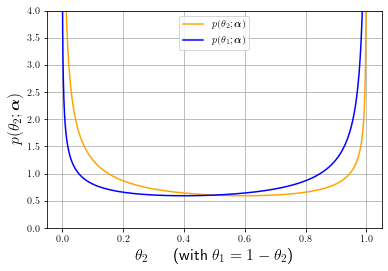

In [16]:
# the Dirichlet distribution
f = ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]-1.))

plt.plot(q1,f, label = r'$p(\theta_2;\boldsymbol{\alpha})$',color='orange')
plt.plot(q0,f, label = r'$p(\theta_1;\boldsymbol{\alpha})$',color='blue')
plt.rc('text', usetex=True)
# plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.xlabel(r'$\theta_2$ \hspace{5mm} (with $\theta_1 = 1-\theta_2$)',fontsize=16)
plt.ylabel(r'$p({\theta_2};\boldsymbol{\alpha})$',
          fontsize=16)
plt.legend()
plt.grid()
plt.ylim(0.0, 4.0)
plt.savefig('dirichud.pdf')
plt.show()


### The Polya distribution $p(Z,\boldsymbol{\theta};\boldsymbol{\alpha})$



Initial Polya distirbution: constructed by multiplying the initial Dirichlet distribution by a flat categorical distribution:


$p(Z_{},{\boldsymbol{\theta}};{\boldsymbol{\alpha}})=\frac{\Gamma(\sum_j\alpha^{}_{j})}{\prod_{j}\Gamma(\alpha^{}_{j})} \prod_{j}\theta_{j}^{\mathbb{[}Z_{}=j\mathbb{]}+\alpha^{}_{j}-1}$

also written as:


$p(Z_{},\boldsymbol{\theta};\boldsymbol{\alpha})=\frac{\Gamma(\sum_j\alpha^{}_{j})}{\prod_{j}\Gamma(\alpha^{}_{j})} \prod_{j}\theta_{j}^{\mathbb{[}Z_{}=j\mathbb{]}}\theta_{j}^{\alpha^{}_{j}-1}$

which is more in line with how it is coded below.

In [6]:
# the Polya distribution
f0 = ac*(np.power(q0,a[0]))*(np.power(q1,a[1]-1.))
f1 = ac*(np.power(q1,a[1]))*np.power(q0,a[0]-1.)


### The Categorical distribution used to modify the Poly distribution $p(Z|\boldsymbol{p})$

The message sent by the cluster to the right of the Polya, to the Polya cluster:

$
  p(Z|\boldsymbol{p})
  = \left\{
  \begin{array}{lr}
    p_{{1}},  && \text{where }  Z = 1\\
    \vdots\\
    p_{{K}},  && \text{where }  Z = K
  \end{array}
  \right.$
  
 or,
 
  $p(Z|\boldsymbol{p}) = \prod_{j} p_j^{[Z=j]}$


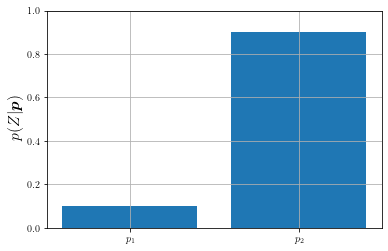

In [7]:
plt.figure(3)
pZlab = [r'$p_1$', r'$p_2$']

plt.rc('text', usetex=True)
plt.bar(pZlab,pZ)
plt.ylabel(r'$p(Z|\boldsymbol{p})$',fontsize=16)
plt.grid()
plt.ylim(0.0, 1.0)
plt.savefig('cat.pdf')
plt.show()


### The updated Polya distribution $p(Z,\boldsymbol{\theta}|\boldsymbol{p},\boldsymbol{\alpha})$ 


Updated Polya distirbution constructed by multiplying new categorical in and the old (flat) one out:

$p(Z,\boldsymbol{\boldsymbol{\theta}}|W=\mathsf{v},\boldsymbol{\alpha}) = \left\{
  \begin{array}{lr}
    \frac{p_1}{d} \frac{\Gamma(\sum_j\alpha_j)}{\prod_j\Gamma(\alpha_j)}\prod_j \theta_j^{[j={1}]+\alpha_j-1},  && \text{where }  Z = 1\\\\
    \vdots\\
    \frac{p_K}{d} \frac{\Gamma(\sum_j\alpha_j)}{\prod_j\Gamma(\alpha_j)}\prod_j \theta_j^{[j={K}]+\alpha_j-1},  && \text{where }  Z = K\\ 
  \end{array}
  \right.$
  
  with $d$ for normalisation as  $d = \frac{\sum_jp_j\alpha_j}{\sum_j\alpha_j}$ 
 

In [8]:
# the updated Polya distribution
f0updated = (1/capZ)*pZ[0]*ac*np.power(q0,a[0])*(np.power(q1,a[1]-1.))
f1updated = (1/capZ)*pZ[1]*ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]))

# The *** true posterior marginal *** after we sum out Z (p)
fP = f0updated+f1updated


### Detemining the approximate Posterior $p(\theta|p,\alpha)$



area1Q= 1.1182369508702221
area2Q= 1.0


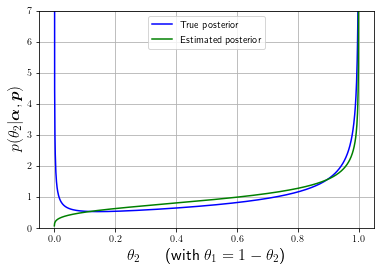

In [9]:
prod = a*pZ;
prod /= np.sum(prod) # renormalise

post = prod+a

# normalising
capost = gamma(np.sum(post))/np.prod(gamma(post))

# the approximated posterior (q), before dividing out the incoming Dirichlet.
fQ =np.power(q0,post[0]-1.)*(np.power(q1,post[1]-1.))

# check it via numerical integration
area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
print('area1Q=',area)
fQ /= area;
area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
print('area2Q=',area)

plt.figure(5)
truePost,= plt.plot(q1,fP,label='True posterior', color="blue")
estPost,= plt.plot(q1,fQ,label='Estimated posterior', color="green")
plt.rc('text', usetex=True)
plt.xlabel(r'$\theta_2$ \hspace{5mm} (with $\theta_1 = 1-\theta_2$)',fontsize=16)
plt.ylabel(r'$p(\theta_2|\boldsymbol{\alpha},\boldsymbol{p})$',
          fontsize=16)
plt.legend(handles=[truePost, estPost])
plt.ylim((0,7))
plt.grid()
plt.savefig('postud.pdf')
plt.show()


In the following we determine what, ideally, the message returning from the Polya cluster towards the Dirichlet cluster should look like.
If we divide by the message that originally came from the Dirichlet cluster, $p(\boldsymbol{\theta};\boldsymbol{\alpha})$,this should give us the 'true' message to send from the Polya to the Dirichlet cluster. Interestingly it is linear!

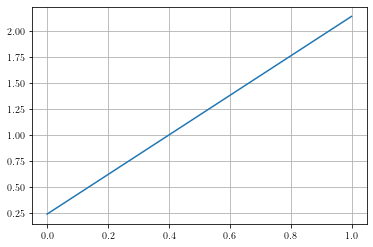

In [10]:

plt.plot(q1,fP/f)
plt.grid()
plt.show()


We can now work backwards to see what the message should have been to create the posterior (we can divide out the original Dirichlet).
Note the $-1$'s below:

  $\frac{p({\theta}; {\alpha})}{p({\theta}; {\beta})}= \frac{\Gamma(\sum_j \alpha_j)\prod_{j}\Gamma(\beta_j)}{\Gamma(\sum_j \beta_j)\prod_{j}\Gamma(\alpha_j)}
  \prod_{j}\theta_j^{(\alpha_j-1) - (\beta_j-1)}$

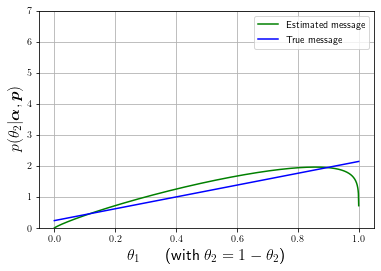

In [11]:
# original Dirichlet (to divide out)
f = ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]-1.))

# the message (posterior / original Dirichlet)
fQmessage = (1/ac)*capost*np.power(q0,post[0]-1.-(a[0]-1))*(np.power(q1,post[1]-1.-(a[1]-1.)))
m_pd = fP/f

plt.figure(5)
estPostmsg,= plt.plot(q1,fQmessage,label='Estimated message', color="green")
Postmsgtrue,= plt.plot(q1,fP/f,label='True message', color="blue")
plt.rc('text', usetex=True)
plt.xlabel(r'$\theta_1$ \hspace{5mm} (with $\theta_2 = 1-\theta_2$)',fontsize=16)
plt.ylabel(r'$p(\theta_2|\boldsymbol{\alpha},\boldsymbol{p})$',
          fontsize=16)
plt.legend(handles=[estPostmsg,Postmsgtrue])
plt.ylim((0,7))
plt.grid()
plt.savefig('approxvsrealud.pdf')
plt.show()


### Using KLD to check performance of approximation



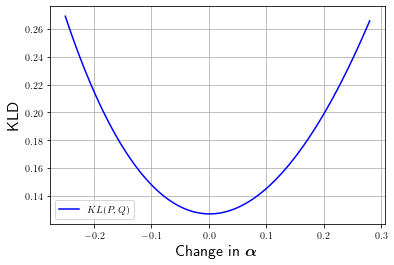

In [15]:
# Approximates KL divergence for 1-D continuous p and q by using numerical integration. 
# Both p and q are continuous probability distributions over RV X. 
# We only know their values at sampled points x.
def kl1_cont(p,q,x):
    K = len(p)
    theProd = np.zeros(K)
    for k in range(0,K):
        if p[k] > 0.0:
            theProd[k] = p[k]*np.log(p[k]/q[k])
    return integrate.simps(theProd, x, dx=1, axis=-1, even='avg')


del_a = np.linspace(-0.25,0.28,100)
div = np.zeros(len(del_a))
div2 = np.zeros(len(del_a))

for k in range( len(del_a) ):
  
    # the alphas passed from the polya to the dirichlet, excluding the incoming dirichlet
    aa = a*pZ;
    aa /= np.sum(aa) # renormalize since it is only one observation
    aa += a

    # change both alphas by del_a[k]
    aa[0] += del_a[k]
    aa[1] -= del_a[k]

    caa = gamma(np.sum(aa))/np.prod(gamma(aa))

    # *** the approximated posterior (q) **, before dividing out the incoming Dirichlet.
    fQ = caa*np.power(q0,aa[0]-1.)*(np.power(q1,aa[1]-1.))
    # check it via numerical integration
    area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
    fQ /= area; # renormalize for the sake of simpson's rule
    area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')

    div[k] = kl1_cont(fQ,fP,q1)
    div2[k] = kl1_cont(fP,fQ,q1)

# plt.plot(del_a,div,label=r'$KL(Q,P)$', color = "orange") 
plt.rc('text', usetex=True)
plt.xlabel(r'Change in $\boldsymbol{\alpha}$',fontsize=16)
plt.plot(del_a,div2,label=r'$KL(P,Q)$', color = "blue")   
plt.ylabel('KLD',
          fontsize=16)
# plt.title(r'KL divergences vs delta alpha',fontsize=16)
# plt.title(r'Posterior KLs with $\alpha=\{$%s, %s$\}, p_x=\{$%s, %s$\}$'%(a[0],a[1],pX[0],pX[1]),fontsize=18)
plt.legend()
plt.grid()
plt.savefig('KLD_EGud.pdf')

plt.show()
